## Data Overview

In [ ]:
from pathlib import Path
import pandas as pd

CSV_PATH = Path("../labels.csv")

df = pd.read_csv(CSV_PATH)
print(df["film_type"].value_counts())

film_type
hp5           507
e100          240
portra160     239
5219          101
5207           72
800t           71
400tmax        70
portra800      70
portra400      65
delta400       61
velvia50       39
400tx          37
delta          36
delta100       35
phoenix200     33
delta3200      32
pan100         31
400            30
5222           29
100tmax        26
100            17
Name: count, dtype: int64


I plan to classify the photos bases on the famous film types and the one I uses most. So the final class is:
- Ilford hp5
- Kodak E100
- Kodak Portra Seires
- Other Colors
- Other B&Ws

So each class has above 200 samples.

In [23]:
from sklearn.model_selection import train_test_split

LABEL = Path("../labels_film.csv")

def film_label(film_type):
    t = film_type.strip().lower()

    ## Ilford hp5
    if t == "hp5":
        return "hp5"
    
    ## Kodak E100
    elif t == "e100":
        return "e100"
    
    ## Kodak Portra Series
    elif t in ["portra160", "portra400", "portra800"]:
        return "portra"
    
    ## Other B&W films
    elif t in ["400tmax","delta400","400tx","delta","delta100","delta3200","pan100","5222","100tmax"]:
        return "other_bw"
    
    ## Other Color films
    else:
        return "other_color"

df["film_label"] = df["film_type"].apply(film_label)

print("\nCounting film_label:")
print(df["film_label"].value_counts())

df.to_csv(LABEL, index=False)
print(f"\nSaved to: {LABEL.resolve()}")


Counting film_label:
film_label
hp5            507
portra         374
other_color    363
other_bw       357
e100           240
Name: count, dtype: int64

Saved to: /home/longwei/CS441/final/labels_film.csv


Splitted into train/test/val

In [25]:
df_train, df_temp = train_test_split(
    df,
    test_size=0.30,  
    stratify=df["film_label"],
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50, 
    stratify=df_temp["film_label"],
    random_state=42
)

df_train = df_train.copy()
df_val   = df_val.copy()
df_test  = df_test.copy()

df_train["split"] = "train"
df_val["split"]   = "val"
df_test["split"]  = "test"

df_all = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)

df_all.to_csv(LABEL, index=False)

print("Saved to:", LABEL.resolve())
print(df_all["split"].value_counts())

Saved to: /home/longwei/CS441/final/labels_film.csv
split
train    1288
test      277
val       276
Name: count, dtype: int64


## Baseline

Resize the photo to a small size.  
Use global mean and std of RGB/HSV do a logistic regression.


### Data Processing
Train:Val:Test = 75:15:15

In [28]:
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ===================== Configuration ======================

CSV = Path("../labels.csv")
RAW = Path("../raw_photos")

# ===================== Data processing ======================

def load_image_rgb(path: Path,
                   size: Tuple[int, int] = (256, 256)) -> np.ndarray:
    """Load an image and convert to RGB format."""
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr

def rgb_to_hsv(image: np.ndarray) -> np.ndarray:
    """Convert an RGB image to HSV format."""
    img = Image.fromarray((image * 255).astype(np.uint8), mode="RGB")
    hsv_img = img.convert("HSV")
    hsv_array = np.asarray(hsv_img, dtype=np.float32) / 255.0
    return hsv_array

def extract_features_rgb_hsv(path: Path) -> np.ndarray:
    """Extract RGB + HSV features from an image."""
    rgb = load_image_rgb(path)            # (H, W, 3)
    hsv = rgb_to_hsv(rgb)             # (H, W, 3)

    r = rgb[..., 0].ravel()
    g = rgb[..., 1].ravel()
    b = rgb[..., 2].ravel()

    h = hsv[..., 0].ravel()
    s = hsv[..., 1].ravel()
    v = hsv[..., 2].ravel()

    feats = [
        r.mean(), g.mean(), b.mean(),
        h.mean(), s.mean(), v.mean(),
        r.std(), g.std(), b.std(),
        h.std(), s.std(), v.std(),
    ]
    return np.array(feats, dtype=np.float32)

def build_dataset(df: pd.DataFrame,
                  img_root: Path) -> tuple[np.ndarray, np.ndarray]:
    """Build dataset from dataframe and image root."""
    xs = []
    ys = []

    for _, row in df.iterrows():
        fname = row["filename"]
        label = row["film_label"]

        img_path = img_root / fname
        if not img_path.is_file():
            print(f"[WARN] Image not found, skip: {img_path}")
            continue

        vec = extract_features_rgb_hsv(img_path)
        xs.append(vec)
        ys.append(label)

    X = np.stack(xs, axis=0)
    y = np.array(ys)
    return X, y


df = pd.read_csv(LABEL)
df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("Building train set features...")
X_train, y_train = build_dataset(df_train, RAW)

print("Building val set features...")
X_val, y_val = build_dataset(df_val, RAW)

print("Building test set features...")
X_test, y_test = build_dataset(df_test, RAW)

print(f"Feature dim: {X_train.shape[1]}")

Building train set features...
Building val set features...
Building test set features...
Feature dim: 12


### Logistic Regression



Training Logistic Regression with C=0.01...
Validation Macro F1: 0.5388
Validation Accuracy: 0.6087

Training Logistic Regression with C=0.1...
Validation Macro F1: 0.6205
Validation Accuracy: 0.6522

Training Logistic Regression with C=1.0...
Validation Macro F1: 0.6239
Validation Accuracy: 0.6486

Training Logistic Regression with C=10.0...
Validation Macro F1: 0.6441
Validation Accuracy: 0.6703

Training Logistic Regression with C=100.0...
Validation Macro F1: 0.6495
Validation Accuracy: 0.6739

Training Logistic Regression with C=1000.0...
Validation Macro F1: 0.6559
Validation Accuracy: 0.6812

Training Logistic Regression with C=10000.0...
Validation Macro F1: 0.6531
Validation Accuracy: 0.6775

Training Logistic Regression with C=100000.0...
Validation Macro F1: 0.6531
Validation Accuracy: 0.6775

Training Logistic Regression with C=1000000.0...
Validation Macro F1: 0.6560
Validation Accuracy: 0.6775


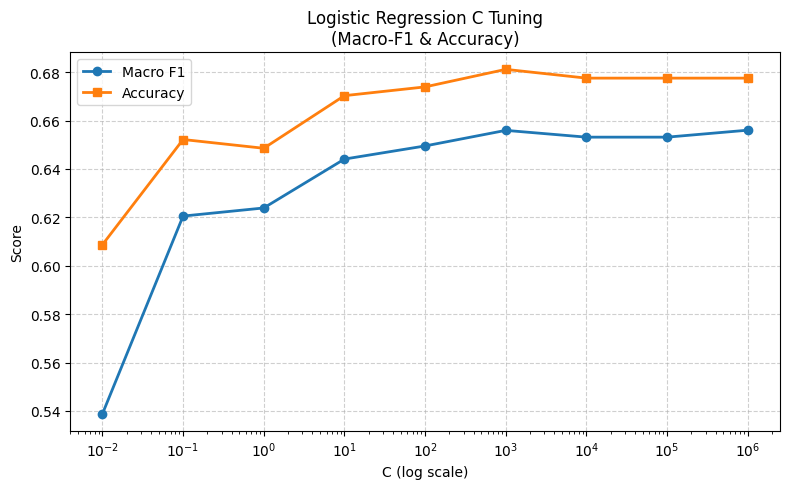


=== Test set performance ===
              precision    recall  f1-score   support

        e100       0.47      0.44      0.46        36
         hp5       0.70      0.72      0.71        76
    other_bw       0.57      0.53      0.55        53
 other_color       0.60      0.67      0.63        55
      portra       0.62      0.58      0.60        57

    accuracy                           0.61       277
   macro avg       0.59      0.59      0.59       277
weighted avg       0.61      0.61      0.61       277

Confusion matrix (test):
[[16  0  0 11  9]
 [ 1 55 20  0  0]
 [ 1 24 28  0  0]
 [ 6  0  1 37 11]
 [10  0  0 14 33]]


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

C = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,100000.0,1000000.0]
macro_f1_list = []
acc_list = []

for c in C:
    print(f"\nTraining Logistic Regression with C={c}...")
    
    clf = LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        C=c,
    )
    
    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)
    macro_f1 = f1_score(y_val, y_val_pred, average="macro")
    macro_f1_list.append(macro_f1)
    print(f"Validation Macro F1: {macro_f1:.4f}")

    acc = clf.score(X_val_scaled, y_val)
    acc_list.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")

# ----------- Plot ------------
plt.figure(figsize=(8, 5))

plt.plot(C, macro_f1_list, marker='o', label="Macro F1", linewidth=2)
plt.plot(C, acc_list, marker='s', label="Accuracy", linewidth=2)

plt.xscale("log") 

plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("Logistic Regression C Tuning\n(Macro-F1 & Accuracy)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

best_clf = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    C=C[np.argmax(macro_f1_list)],
)
best_clf.fit(X_train_scaled, y_train)

print("\n=== Test set performance ===")
y_test_pred = best_clf.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

## CLIP

Use Pre-trained CLIP-Vit-B-32 to embed a photo  
Use logistic regression to classify the photo  

In [57]:
from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import open_clip

# ===================== Configuration ======================
RAW = Path("../raw_photos")
LABEL = Path("../labels_film.csv")
OUT_DIR = Path("../clip_features")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===================== Dataset ======================
class FilmDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 img_root: Path,
                 preprocess) -> None:
        self.df = df
        self.img_root = img_root
        self.preprocess = preprocess

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        row = self.df.iloc[index]
        fname = row["filename"]
        label = row["film_label"]
        img_path = self.img_root / fname
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.preprocess(img)

        return img_tensor, label


def extract_clip_features(split: str,
                          model: torch.nn.Module,
                          preprocess,
                          device: torch.device,
                          batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    """Extract CLIP features from dataloader using the given model."""
    df_split = df[df["split"] == split].reset_index(drop=True)

    dataset = FilmDataset(df_split, RAW, preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    all_feats = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch_imgs, batch_labels in loader:
            batch_imgs = batch_imgs.to(device)
            image_features = model.encode_image(batch_imgs) 
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            feats_np = image_features.cpu().numpy()
            all_feats.append(feats_np)
            all_labels.extend(batch_labels)

    X = np.concatenate(all_feats, axis=0)  
    y = np.array(all_labels)    
    print(f"Features shape: {X.shape}, labels shape: {y.shape}")
    return X, y
    
# ===================== Model ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-B-32",
        pretrained="laion2b_s34b_b79k"
    )
model.to(device)
model.eval()

features = {}
df = pd.read_csv(LABEL)
for split in ["test", "val", "train"]:
    print(f"\nExtracting features for split: {split}...")
    X, y = extract_clip_features(split, model, preprocess, device)
    features[split] = (X, y)
    np.savez(OUT_DIR / f"clip_{split}.npz", X=X, y=y)

print("\n✅ All splits extracted and saved to:", OUT_DIR)

Using device: cuda

Extracting features for split: test...
Features shape: (277, 512), labels shape: (277,)

Extracting features for split: val...
Features shape: (276, 512), labels shape: (276,)

Extracting features for split: train...
Features shape: (1288, 512), labels shape: (1288,)

✅ All splits extracted and saved to: ../clip_features
